# Individual Participant Analysis

In [2]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as stats
from scipy import stats
from statsmodels.stats.anova import AnovaRM
import copy

In [3]:
# _dir = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/verbal_judgement_analysis'
_dir = '/Users/pmahableshwarkar/Documents/Depth_Project/verbal_judgement_analysis'


raw_dir = _dir + '/data/finalVEMatched/raw'
zs_dir = _dir + '/data/finalVEMatched/z_scored'

final_data = pd.read_csv (raw_dir + '/raw_data.csv')
zscored_data = pd.read_csv (zs_dir + '/z_scored_data.csv')

## Get Model Prediction for Depth from Linear Regressions 

In [5]:
def trial_pivotTable(data):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each individual target (stimulus) the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """
    
    avg_tables = []
    std_tables = []
    result_tables = []
    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    cond = 0
    for duration in data: #generate pivot tables for data statistics (avg, std, sem)
        actual = pd.pivot_table(duration,  values = ["actual_depth"], columns=['stimulus'], aggfunc=np.mean)
        actual.reset_index()
        actual_renamed = actual.rename(index={'actual_depth': 'Actual Depth'})
        
        avg = pd.pivot_table(duration,  values = ["depth_estimate"], columns=['stimulus'], aggfunc=np.mean)
        avg.reset_index()
        avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
        RT = pd.pivot_table(duration,  values = ["trial_RT"], columns=['stimulus'], aggfunc=np.mean)
        RT.reset_index()
        RT_renamed = RT.rename(index={'trial_RT': 'Average Trial RT'})
        
        std = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = np.std)
        #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
        std.reset_index()
        std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
        sem = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = 'sem')
        sem.reset_index()
        sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
        frames = [avg_renamed, std_renamed, sem_renamed, actual_renamed, RT_renamed] #list of pivot tables for a given duration
        result = pd.concat(frames) #merge the pivot tables for a given duration 
        result = result.T #transpose 
        result = result.sort_values(by=['Actual Depth'])

        #Label the data by duration based on condition counter (cond)
        if cond == 0:
            result["Duration"] = 125
        if cond == 1:
            result["Duration"] = 250
        if cond == 2:
            result["Duration"] = 1000
        
        avg_tables.append(avg_renamed) #created for reference (not used in code)
        std_tables.append(std_renamed) #created for reference (not used in code)
        result_tables.append(result) #list of results for all durations 
        cond += 1 
        
    
    return result_tables

In [6]:
z_data_125ms = zscored_data[zscored_data['duration'] == 125]
z_data_250ms = zscored_data[zscored_data['duration'] == 250]
z_data_1000ms = zscored_data[zscored_data['duration'] == 1000]

zscored_duration_data = [z_data_125ms, z_data_250ms, z_data_1000ms]

In [7]:
zscored_trial_pivot = trial_pivotTable(zscored_duration_data)


In [8]:
def trial_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    Args:
        df = [125, 250, 1000]
        These data frames are POST all outlier cleaning. 
        
    Returns:
        actualdepths = [x_125, x_250, x_1000]
        xs = [list of individual targets]
        ys = [y_125, y_250, y_1000]
        stes = [ste_125, ste_250, ste_1000]
        
    """
    xs = []
    ys = []
    stes = []
    stds = []
    actualdepths = []
    trial_RTs = []
    for table in data:
        x = []
        y = []
        ste = []
        std = []
        depths = []
        RT = []
        for idx, row in table.iterrows():
            
            x.append(idx) #idx is the target (stimulus path)
            
            estim_avg = row["Average Estimated Depth"]
            y.append(estim_avg)
            
            standard_error = row["Standard Error"]
            ste.append(standard_error)
            
            depth = row["Actual Depth"]
            depths.append(depth)
            
            standard_deviation = row["Standard Deviation"]
            std.append(standard_deviation)       
            
            reactionTime = row["Average Trial RT"]
            RT.append(reactionTime)  
            
        xs.append(x)
        ys.append(y)
        stes.append(ste)
        actualdepths.append(depths)
        stds.append(std)
        trial_RTs.append(RT)

    return xs, ys, stes, actualdepths, stds, trial_RTs

In [9]:
trial_zscored_final = trial_getxy(zscored_trial_pivot)


In [10]:
z_trial_plot_data = trial_zscored_final

## Execute this cell to prep for plotting

z_final_x_125 = z_trial_plot_data[0][0]
z_final_y_125 = z_trial_plot_data[1][0]
z_ste_125 = z_trial_plot_data[2][0]
z_stim_125 = z_trial_plot_data[3][0]
z_std_125 = z_trial_plot_data[4][0]
z_RT_125 = z_trial_plot_data[5][0]

z_final_x_250 = z_trial_plot_data[0][1]
z_final_y_250 = z_trial_plot_data[1][1]
z_ste_250 = z_trial_plot_data[2][1]
z_stim_250 = z_trial_plot_data[3][1]
z_std_250 = z_trial_plot_data[4][1]
z_RT_250 = z_trial_plot_data[5][1]

z_final_x_1000 = z_trial_plot_data[0][2]
z_final_y_1000 = z_trial_plot_data[1][2]
z_ste_1000 = z_trial_plot_data[2][2]
z_stim_1000 = z_trial_plot_data[3][2]
z_std_1000 = z_trial_plot_data[4][2]
z_RT_1000 = z_trial_plot_data[5][2]

m: [0.48883697]
b: -1.4943760293918529
R-squared:  0.6784855257844219


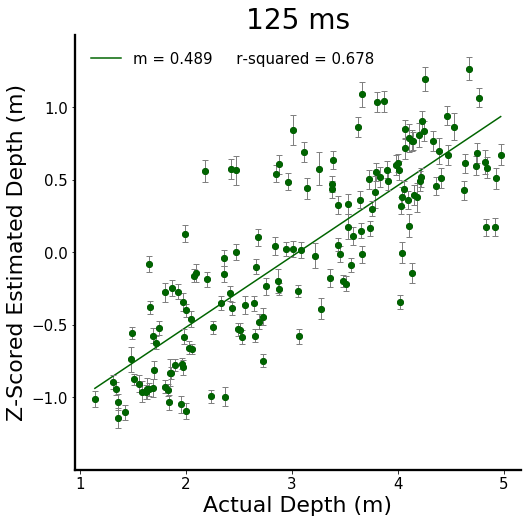

In [12]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(z_stim_125).reshape(-1,1)
y = z_final_y_125
ste = z_ste_125
std = z_std_125

reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='darkgreen', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))
plt.title("125 ms", fontsize = 28)
plt.xlabel("Actual Depth (m)", fontsize = 22)
plt.ylabel("Z-Scored Estimated Depth (m)", fontsize = 22)
# plt.plot(X, X, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkgreen", mec = "darkgreen", capsize = 3)



plt.xticks(np.arange(1, 6, 1), fontsize=15)
plt.yticks(np.arange(-1,1.5, 0.5), fontsize=15)
plt.ylim(-1.5,1.5)


legend = plt.legend(loc = 0, fontsize = 15, borderpad = 0.6, labelspacing = 1, frameon=False)
# legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

z_residuals_125 = copy.deepcopy(y - y_predicted)

model_prediction_125 = copy.deepcopy(y_predicted)

m: [0.52470942]
b: -1.604102054965354
R-squared:  0.7322942306805682


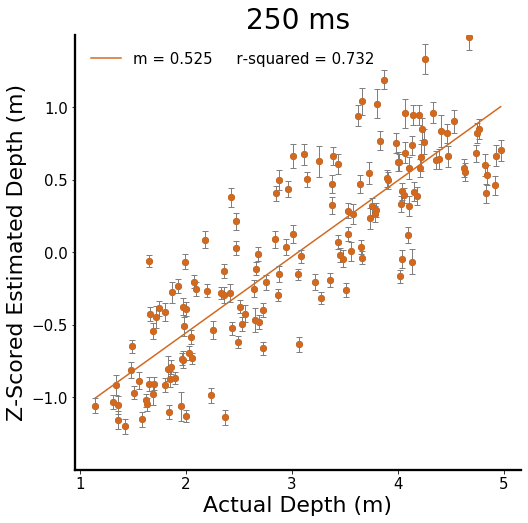

In [13]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)


#run regression
X = np.array(z_stim_250).reshape(-1,1)
y = z_final_y_250
ste = z_ste_250
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='chocolate', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))
plt.title("250 ms", fontsize = 28)
plt.xlabel("Actual Depth (m)", fontsize = 22)
plt.ylabel("Z-Scored Estimated Depth (m)", fontsize = 22)
plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)
# plt.plot(X, X, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.xticks(np.arange(1, 6, 1), fontsize=15)
plt.yticks(np.arange(-1,1.5, 0.5), fontsize=15)
plt.ylim(-1.5,1.5)



legend = plt.legend(loc = 0, fontsize = 15, borderpad = 0.6, labelspacing = 1, frameon=False)
# legend.get_frame().set_facecolor('lightgray')


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

z_residuals_250 = copy.deepcopy(y - y_predicted)
model_prediction_250 = copy.deepcopy(y_predicted)

m: [0.54404931]
b: -1.6632086005118043
R-squared:  0.7352421581453547


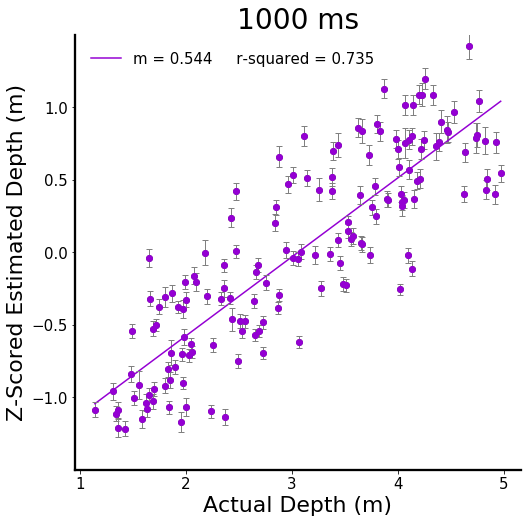

In [14]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

#run regression
X = np.array(z_stim_1000).reshape(-1,1)
y = z_final_y_1000
ste = z_ste_1000
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black', alpha = 0.5);
plt.plot(X,y_predicted,color='darkviolet', label = 'm = ' + str(round(reg.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg.score(X, y)), 3)))
plt.title("1000 ms", fontsize = 28)
plt.xlabel("Actual Depth (m)", fontsize = 22)
plt.ylabel("Z-Scored Estimated Depth (m)", fontsize = 22)
plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "darkviolet", mec = "darkviolet", capsize = 3)
# plt.plot(X, X, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.xticks(np.arange(1, 6, 1), fontsize=15)
plt.yticks(np.arange(-1,1.5, 0.5), fontsize=15)
plt.ylim(-1.5,1.5)

legend = plt.legend(loc = 0, fontsize = 15, borderpad = 0.6, labelspacing = 1, frameon=False)
# legend.get_frame().set_facecolor('lightgray')

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

round(float(reg.score(X, y)), 3)

z_residuals_1000 = copy.deepcopy(y - y_predicted)
model_prediction_1000 = copy.deepcopy(y_predicted)

In [23]:
folders = [elem.split('/')[1][:-2] for elem in z_final_x_125]

len(model_prediction_125), len(model_prediction_250), len(model_prediction_1000), len(folders)

(156, 156, 156, 156)

In [46]:
model_prediction_dict = {}

for i, folder in enumerate(folders, 0):
    model_prediction_dict[folder] = {'125': model_prediction_125[i], '250': model_prediction_250[i], '1000': model_prediction_1000[i]}

model_prediction_dict['002272_2014-06-28_18-53-56_260595134347_rgbf000067-resize']

({'125': -0.9380795536749361,
  '250': -1.0069827359494818,
  '1000': -1.0440804835482904},
 -0.9380795536749361)

In [61]:
all_subjs = zscored_data.subjID.unique()
all_stim = zscored_data.stimulus.unique()

subj_residuals = {'subjID': [], 'duration': [], 's_residual': [], 'abs_s_residual': [], 'stimulus': []}

for subj in all_subjs:
    subj_df = zscored_data.loc[zscored_data['subjID'] == subj] 
    
    duration = int(subj_df.duration.unique()[0])
    
#     print(subj_df['depth_estimate'].count())
    
    for stim in all_stim:
        stim_df = subj_df.loc[subj_df['stimulus'] == stim] 
        if len(list(stim_df['depth_estimate'])) > 0:
            estimate = list(stim_df['depth_estimate'])[0]
            # residual = estimate - predicted 
            s_residual = estimate - model_prediction_dict[stim.split('/')[1][:-2]][str(duration)]
            abs_s_residual = abs(s_residual)        

            subj_residuals['subjID'].append(subj)
            subj_residuals['duration'].append(duration)
            subj_residuals['s_residual'].append(s_residual)
            subj_residuals['abs_s_residual'].append(abs_s_residual)
            subj_residuals['stimulus'].append(stim.split('/')[1][:-2])

In [64]:
final_df = pd.DataFrame(data=subj_residuals)
final_df

,subjID,duration,s_residual,abs_s_residual,stimulus
0,541423.0,125,0.906977,0.906977,001808_2014-06-26_20-50-58_260595134347_rgbf00...
1,541423.0,125,1.590297,1.590297,001815_2014-06-26_20-52-55_260595134347_rgbf00...
2,541423.0,125,-0.355174,0.355174,001029_2014-06-08_13-17-57_260595134347_rgbf00...
3,541423.0,125,-0.847848,0.847848,000677_2014-06-08_23-10-32_260595134347_rgbf00...
4,541423.0,125,-0.403006,0.403006,002118_2014-06-25_20-32-08_260595134347_rgbf00...
...,...,...,...,...,...
71127,351649.0,250,0.593507,0.593507,002875_2014-06-01_15-19-00_094959634447_rgbf00...
71128,351649.0,250,-0.542151,0.542151,001092_2014-06-15_17-34-58_260595134347_rgbf00...
71129,351649.0,250,-0.513911,0.513911,002545_2014-06-24_13-38-53_094959634447_rgbf00...
71130,351649.0,250,0.277538,0.277538,001167_2014-06-17_15-38-07_260595134347_rgbf00...


In [65]:
dst = '/Users/pmahableshwarkar/Documents/Depth_Project/verbal_judgement_analysis/data/finalVEMatched/z_scored/residuals/'
final_df.to_csv(dst + 'participant_residuals.csv', index=False)